In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from collections import Counter
import umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE



from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score

# Load data
data1_raw = pd.read_csv("data1.csv.gz")

# Separate the target (Y) and predictors (X)
y = np.where(data1_raw.iloc[:, 0] == "TREG", 1, 0).astype(np.float64)  # 1 if "TREG", else 0
X = data1_raw.iloc[:, 1:]  # all other columns are predictors


# Initial Setup: Functions

Core functions we use:

1. evaluate_classifiers - LDA, QDA, Logistic, k-NN, Gradient Boosting, Random Forest
2. tune_svm_hyperparameters - Grid Search method to find best reg parameter, Kernel type and coefficient for SVM
3. svm_classifier_with_best_params - Running SVM with tuned parameters 
4. knn_best_k_f1 - find best k for k-NN using Cross-Validation 
5. mypredict() - Task requirement

In [31]:
def evaluate_classifiers(X_train, X_test, y_train, y_test, best_k):
    """
    Trains multiple classifiers and evaluates them on the test set.
    
    Parameters:
    - X_train, X_test: Training and test features
    - y_train, y_test: Training and test labels
    - k_neighbors: Number of neighbors for k-NN classifier (default: 5)
    
    Returns:
    - DataFrame with classifiers as rows and metrics as columns
    """
    classifiers = {
        "LDA": LinearDiscriminantAnalysis(),
        "QDA": QuadraticDiscriminantAnalysis(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "k-NN": KNeighborsClassifier(n_neighbors=best_k),
        "GBDT": GradientBoostingClassifier(),
        "Random Forest": RandomForestClassifier(n_estimators=100),
    }
    
    results = []
    
    for name, clf in classifiers.items():
        # Fit the model
        clf.fit(X_train, y_train)
        
        # Predict and calculate metrics
        y_pred = clf.predict(X_test)
        
        # Some classifiers may not support probability estimates (e.g., LDA, QDA, Logistic in certain cases)
        # Check if predict_proba is available before calculating AUC
        if hasattr(clf, "predict_proba"):
            y_prob = clf.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_prob)
        else:
            auc = None
        
        accuracy = accuracy_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Append results to the list
        results.append({
            "Classifier": name,
            "Accuracy": round(accuracy, 3),
            "Balanced Accuracy": round(balanced_accuracy, 3),
            "AUC": round(auc, 3) if auc is not None else "N/A",
            "F1 Score": round(f1, 3)
        })
    
    # Create DataFrame
    results_df = pd.DataFrame(results).set_index("Classifier")
    
    return results_df


In [24]:
#Functions used in Tuning: 

def elastic_net_logistic_regression(X_train, X_test, y_train, y_test):
    """
    Trains a logistic regression classifier with Elastic Net regularization using GridSearchCV 
    to optimize F1 score. Returns evaluation metrics on the test set.

    Parameters:
    - X_train: Training features
    - X_test: Test features
    - y_train: Training labels
    - y_test: Test labels

    Returns:
    - Dictionary of evaluation metrics (accuracy, balanced accuracy, AUC, F1 score)
    """
    # Define the model
    logistic = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=10000)
    
    # Define the parameter grid for C and l1_ratio
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strengths to try
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Mixing ratios for Elastic Net
    }
    
    # Set up the grid search with F1 score as the scoring metric
    grid_search = GridSearchCV(
        logistic, 
        param_grid, 
        scoring='f1', 
        cv=10,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Get the best model with the optimal hyperparameters
    best_model = grid_search.best_estimator_
    
    # Predict on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # For AUC calculation
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    
    # Return metrics as a dictionary
    return {
        'Accuracy': round(accuracy, 3),
        'Balanced Accuracy': round(balanced_accuracy, 3),
        'AUC': round(auc, 3),
        'F1 Score': round(f1, 3),
        'best_params': grid_search.best_params_
    }


def tune_svm_hyperparameters(X_train, y_train):
    """
    Tune hyperparameters for an SVM classifier using GridSearchCV.

    Parameters:
    - X_train: Training feature set.
    - y_train: Training labels.

    Returns:
    - best_model: The SVM model with the best hyperparameters.
    - best_params: The best hyperparameters found by GridSearchCV.
    - best_score: The best cross-validated score achieved by the best model.
    """

    # Set up the pipeline with scaling and SVM
    svm_pipeline = make_pipeline(StandardScaler(), SVC(probability=True))

    # Define the grid of parameters to search
    param_grid = {
        'svc__C': [0.1, 1, 10, 100],              # Regularization parameter
        'svc__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
        'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1]  # Kernel coefficient
    }

    # Set up GridSearchCV with cross-validation and F1 scoring
    grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

    # Run the grid search
    grid_search.fit(X_train, y_train)

    # Get the best model, parameters, and score
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_model, best_params, best_score

def svm_classifier_with_best_params(X_train, X_test, y_train, y_test, best_params):
    """
    Trains an SVM classifier using the best hyperparameters found by GridSearchCV 
    and returns the evaluation metrics on the test set.
    
    Parameters:
    - X_train: Training features
    - X_test: Test features
    - y_train: Training labels
    - y_test: Test labels
    - best_params: Dictionary of the best parameters for SVM (from GridSearchCV)
    
    Returns:
    - Dictionary of evaluation metrics (accuracy, balanced accuracy, AUC, F1 score)
    """
    # Initialize SVM with best parameters
    svm_model = SVC(
        C=best_params['svc__C'],
        kernel=best_params['svc__kernel'],
        gamma=best_params.get('svc__gamma'),  # use 'gamma' if it's in best_params, otherwise default to 'scale'
        probability=True  # Set probability=True to enable AUC computation
    )
    
    # Train the model
    svm_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = svm_model.predict(X_test)
    y_prob = svm_model.predict_proba(X_test)[:, 1]  # Probability estimates for AUC
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    
    # Return metrics as a dictionary
    return {
        'Accuracy': round(accuracy, 3),
        'Balanced Accuracy': round(balanced_accuracy, 3),
        'AUC': round(auc, 3),
        'F1 Score': round(f1, 3)
    }

def knn_best_k_f1(X_train, X_test, y_train, y_test, max_k=20, cv=5):
    """
    Iterates over different k values to find the best k that maximizes the F1 score.
    Plots F1 scores for training, test, and cross-validation samples for each k.
    
    Parameters:
    - X_train: Training features
    - X_test: Test features
    - y_train: Training labels
    - y_test: Test labels
    - max_k: Maximum number of neighbors to test
    - cv: Number of cross-validation folds
    
    Returns:
    - best_k: The value of k with the highest cross-validation F1 score
    - f1_scores: Dictionary containing training, test, and CV F1 scores for each k
    """
    train_f1_scores = []
    test_f1_scores = []
    cv_f1_scores = []

    # Iterate over k values from 1 to max_k
    for k in range(1, max_k + 1):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Fit and predict on training set for training F1 score
        knn.fit(X_train, y_train)
        y_train_pred = knn.predict(X_train)
        train_f1 = f1_score(y_train, y_train_pred)
        train_f1_scores.append(train_f1)
        
        # Predict on test set for test F1 score
        y_test_pred = knn.predict(X_test)
        test_f1 = f1_score(y_test, y_test_pred)
        test_f1_scores.append(test_f1)
        
        # Cross-validation F1 score
        cv_f1 = cross_val_score(knn, X_train, y_train, cv=cv, scoring='f1').mean()
        cv_f1_scores.append(cv_f1)
    
    # Find the best k with the highest CV F1 score
    best_k = np.argmax(cv_f1_scores) + 1  # Add 1 because index 0 corresponds to k=1
    best_cv_f1_score = cv_f1_scores[best_k - 1]

    # Plot the F1 scores for each k
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, max_k + 1), train_f1_scores, marker='o', linestyle='-', color='blue', label='Training F1 Score')
    plt.plot(range(1, max_k + 1), test_f1_scores, marker='o', linestyle='-', color='green', label='Test F1 Score')
    plt.plot(range(1, max_k + 1), cv_f1_scores, marker='o', linestyle='-', color='red', label='CV F1 Score')
    
    plt.axvline(x=best_k, color='purple', linestyle='--', label=f'Best k = {best_k} (CV F1 Score = {best_cv_f1_score:.3f})')
    
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("F1 Score")
    plt.title("k-NN F1 Score vs. Number of Neighbors (k)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    # Return results in a dictionary
    return {
        "best_k": best_k,
        "train_f1_scores": train_f1_scores,
        "test_f1_scores": test_f1_scores,
        "cv_f1_scores": cv_f1_scores,
        "best_cv_f1_score": best_cv_f1_score
    }

In [ ]:
#function to output txt file 

def mypredict():
    """
    Implements the best classifier (Logistic Regression with Elastic Net Regularization)
    using the known optimal hyperparameters.

    Returns:
    Predict the class label of each row and returns the prediction labels saved in a plain text file
    (one prediction label per line)
    """
    
    data1_raw = pd.read_csv("test.csv.gz")

    # Separate the target (Y) and predictors (X)
    y = np.where(data1_raw.iloc[:, 0] == "TREG", 1, 0).astype(np.float64)  # 1 if "TREG", else 0
    X = data1_raw.iloc[:, 1:]  # all other columns are predictors
    
    # Standardize the predictor variables (important for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce to 10 components
    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame with the reduced components
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(10)])
    
    # We define the logistic regression model with optimal hyperparameters
    best_model = LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        C=1,
        l1_ratio=0.1,
        max_iter=10000
    )
    
    # We fit the model on the PCA-transformed training data
    best_model.fit(X_pca_df, y)
    
    # Evaluate the model on the test set
    y_pred = best_model.predict(X_pca_df)


    # Write predictions to a text file, one per line
    with open("output.txt", "w") as file:
        for pred in y_pred:
            file.write(f"{pred}\n")
    
    
    return y_pred

# T1.1: Exploratory Data Analysis

We answer a series of questions in our Exploratory Data Analysis:

1. Are both classes prevalent in the data set or is there a heavy skew? 
2. Is there multicollinearity in the data set? 
3. Considering the high dimensionality of the data set - are we sure the classes are separable? Usual box plots will not do the trick here and instead we use a UMAP visualisation. 
4. Which genes are important in classification? We run a random forest and plot a variable importance measure. 

Having established in 3. that the classes are not easily separable, we need to reduce dimensions and identify some "key genes" to continue exploring the data. We then have some follow up questions in these dimension reduction methods:  
 
5. In our 10-component PCA, which genes turn out to be influential? We define influential as the top 8 most common features across the top 25 highest absolute value loadings for each component. In other words these are the 8 features that are most influencing the nature of our principal components.
6. When we run a naive logistic regression (with L1 penalty to ensure some variables drop out), which features have the largest coefficients? Do these features on their own offer strong predictive ability?

For both 4 and 5 we plot boxplots to see if those individual features have much predictive power over the binary Y. 

In [5]:
#1. Are both classes prevalent in the data set or is there a heavy skew? 

y = pd.Series(y) 

value_counts = y.value_counts()

print(value_counts)

0.0    3356
1.0    2115
Name: count, dtype: int64


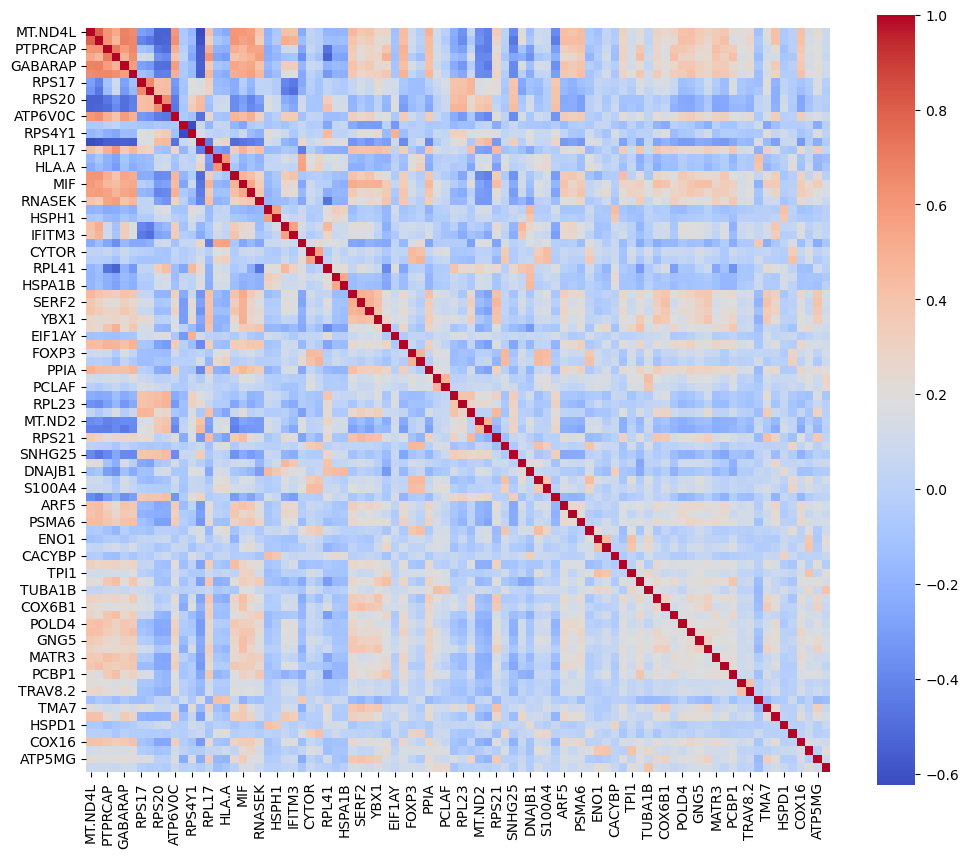

In [30]:
#Question 2: Is there multicollinearity in the data set? 

# Step 1: Calculate the correlation matrix
correlation_matrix = X.corr()

# Step 2: Get the absolute value of the correlations
abs_corr = correlation_matrix.abs()

# Step 3: Set the threshold for high correlation
threshold = 0.4  

# Step 4: Get the pairs of highly correlated genes
# Create a mask for the correlation matrix based on the threshold
mask = (abs_corr >= threshold) & (abs_corr < 1)  # Exclude self-correlation (1.0)

# Extract the highly correlated pairs
high_corr_pairs = abs_corr[mask]

# Step 5: Create a DataFrame to visualize only the most correlated pairs
# Convert the mask to a long-form DataFrame
high_corr_df = high_corr_pairs.stack().reset_index()
high_corr_df.columns = ['Gene1', 'Gene2', 'Correlation']

# Optional: Sort by correlation
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

# Step 6: Create a heatmap for the most correlated genes
# Select unique genes from the pairs
most_correlated_genes = pd.concat([high_corr_df['Gene1'], high_corr_df['Gene2']]).unique()

# Filter the original correlation matrix for these genes
filtered_corr_matrix = correlation_matrix.loc[most_correlated_genes, most_correlated_genes]

# Step 7: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.show()

We set a threshold of > 0.4 for Pearson Coefficients before those variables are even plotted in the above heatmap. Considering almost all the features are not present on this heatmap and even amongst those present the highest is around 0.7, we can conclude there is minimal mutli-collinearity in the data which is a key assumption for most of our analysis later on. 

/opt/homebrew/Caskroom/miniconda/base/envs/LSE/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


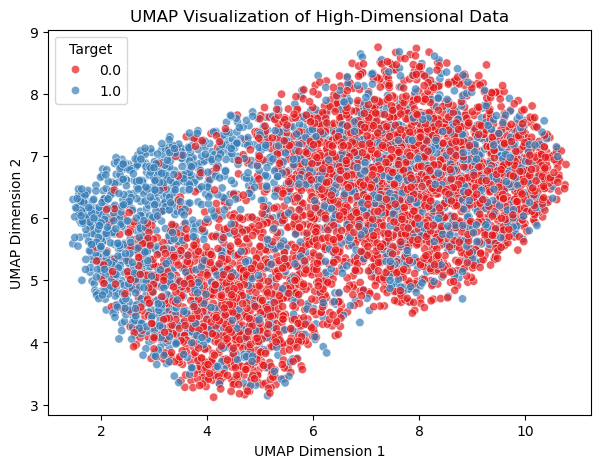

In [29]:
# 3. Considering the high dimensionality of the data set - are we sure the classes are separable? 
# Usual box plots will not do the trick here and instead we use a UMAP visualisation. 

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply UMAP to reduce to 2 dimensions
umap_model = umap.UMAP(n_components=2, random_state=0, n_neighbors=30, min_dist=0.4)
X_umap = umap_model.fit_transform(X_scaled)

# Step 3: Convert UMAP result to a DataFrame for easier plotting
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
umap_df['Target'] = y  # Append the target variable

# Step 4: Plot the UMAP results with Seaborn
plt.figure(figsize=(7, 5))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Target', data=umap_df, palette="Set1", alpha=0.7)
plt.title("UMAP Visualization of High-Dimensional Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Target')
plt.show()

From the above UMAP plot we can see that the classes are not easily separable. We played around with different parameter settings and were not able to improve the clustering. This informs us that we should be doing some sort of dimension reduction to understand the data better. 

/var/folders/7m/ls9fd7f54kq_8_64h69bskkr0000gn/T/ipykernel_46856/1633852436.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette="viridis")


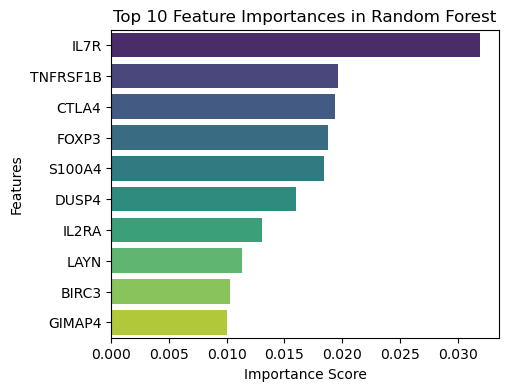

In [20]:
# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Extract feature importances
importances = rf.feature_importances_

# Create a DataFrame to pair feature names with their importance scores
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(5, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette="viridis")
plt.title('Top 10 Feature Importances in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

Here we have plotted top 10 variable's by importance on a scale from 0-1 and can see that while most variables have low importance, IL7R stands out compared to its peers at 3%. We notice something interesting about IL7R later as well. 

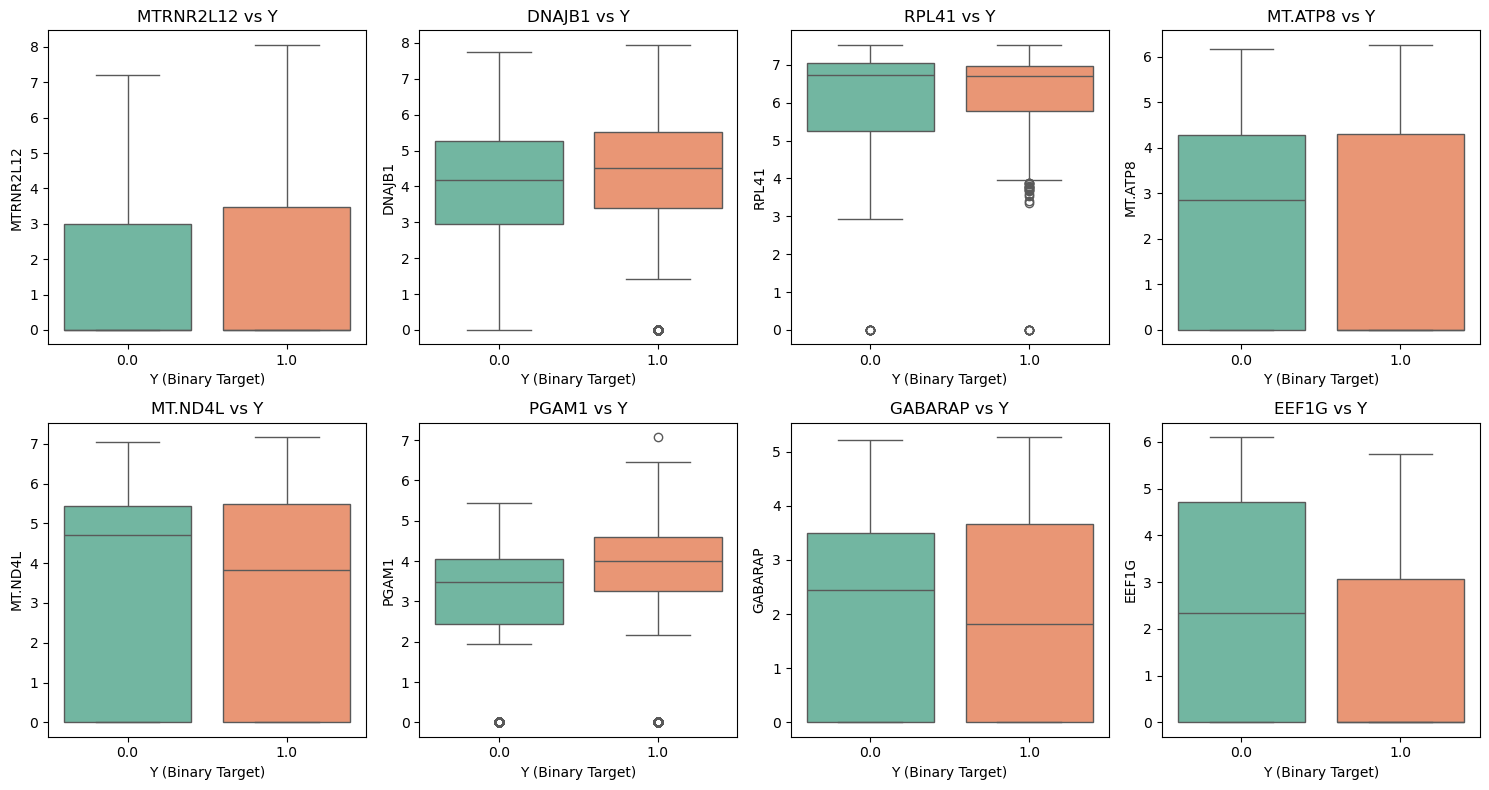

In [9]:
#4. In our 10-component PCA, which genes turn out to be influential? 
# We define influential as the top 8 most common features across the top 25 highest absolute value loadings for each component. 
# In other words these are the 8 features that are most influencing the nature of our principal components. 

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with 10 components
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

# Get feature importances (absolute values of loadings)
loadings = np.abs(pca.components_)

# Get feature names from the DataFrame
feature_names = X.columns.tolist()

# Identify top 25 features per principal component
top_n = 25
top_features = []
for i in range(n_components):
    # Get the indices of the top N features for this component
    component_indices = loadings[i].argsort()[-top_n:][::-1]
    # Convert indices to feature names and add them to the list
    top_features.extend([feature_names[idx] for idx in component_indices])

# Find the 8 most common features across components
top_common = 8
common_features = Counter(top_features).most_common(top_common)

# Convert `X` to a DataFrame if it’s not already
X_df = pd.DataFrame(X, columns=feature_names)

# Add `y` as a new column to `X_df`
X_df['y'] = y

# Reorder columns to make `y` the first column
X_df = X_df[['y'] + [col for col in X_df.columns if col != 'y']]

# List of top common features (identified from previous step)
top_common_features = [feature for feature, _ in common_features]

# Generate box plots for each top feature vs. binary target `y`
plt.figure(figsize=(15, 8))
for i, feature in enumerate(top_common_features, 1):
    plt.subplot(2, 4, i)  # Adjust the grid (2x5) for the top 10 features
    sns.boxplot(x='y', y=feature, data=X_df, palette="Set2", hue='y', legend = False)
    plt.title(f"{feature} vs Y")
    plt.xlabel("Y (Binary Target)")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

Unfortunately, even our most influential features across our 10 principal components do not show much predictive power on their own.

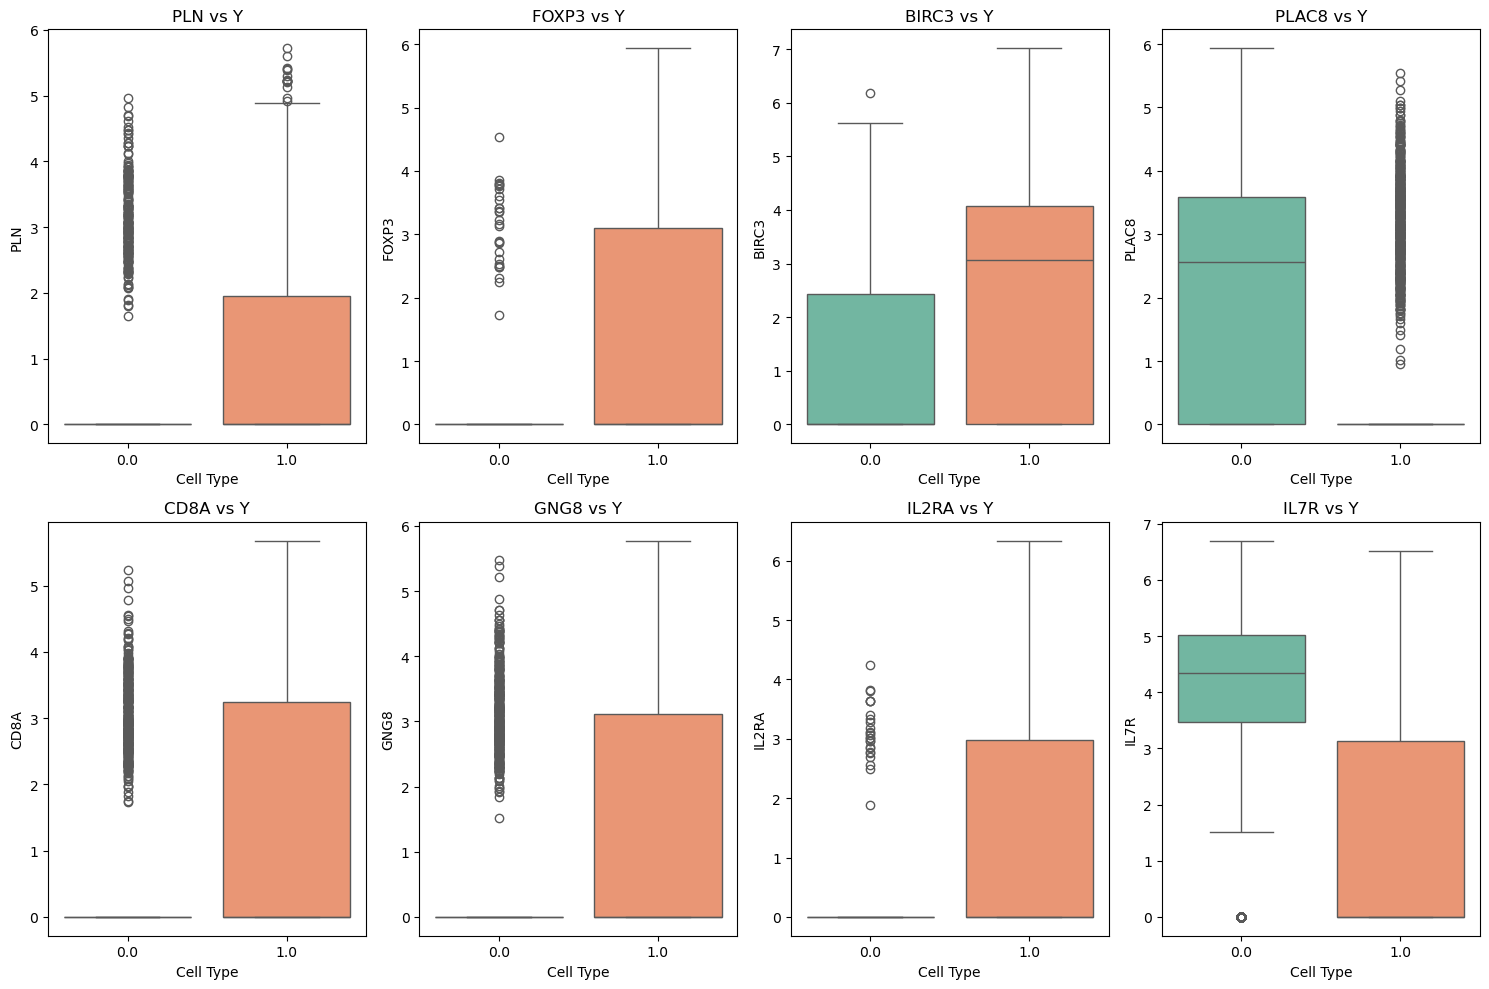

In [21]:
#5. In a naive logistic regression (with L1 penalty to ensure some variables drop out), which features have the largest coefficients? 
# Do these features on their own offer strong predictive ability?

# Train logistic regression with L1 regularization (so as to have feature selection)
log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)  # Use 'liblinear' for L1 regularization
log_reg.fit(X_scaled, y)

# Get absolute values of coefficients and select the top 10 most relevant features
feature_importance = np.abs(log_reg.coef_[0])
top_indices = np.argsort(feature_importance)[-8:]  # Get indices of top 10 features
top_features = X.columns[top_indices]  # Feature names

# Create a DataFrame with top features and target variable for visualization
data_top_features = X[top_features].copy()
data_top_features['y'] = y  # Append the target variable to this DataFrame

# Plot box plots for each of the top features against the target variable
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 4, i)  # Arrange in a 2x5 grid
    sns.boxplot(x='y', y=feature, data=data_top_features, hue='y', palette="Set2", dodge=False, legend=False)
    plt.title(f'{feature} vs Y')
    plt.xlabel("Cell Type")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

We are able to distinguish fairly well with IL7R. This is the same gene we highlighted in the variable importance measure plot! 

While the boxplots for the rest of the top 10 do tend to overlap, their means are atleast mostly distinguishable. This gives us some insight into the fact that a logistic regression might be a good classifier here but this is merely intuition now and we continue to test this in later sections. 

# T1.2: Training Classifiers

In this section we train classifiers without dimension reduction and without hyper tuning parameters to improve F1 Scores. In cases like k-NN or SVM which require parameter choices we use naive default parameters. We take a training-test split of 70-30 by convention. 

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

metrics_df = evaluate_classifiers(X_train, X_test, y_train, y_test, best_k=10)

# Define default parameters for SVM - we will tune these later to improve
default_params = {
    'svc__C': 100,               # Default C parameter in scikit-learn - 1.0
    'svc__kernel': 'rbf',         # Default kernel - rbf
    'svc__gamma': 0.1         # Default gamma setting in scikit-learn - scale
}

# Run the function using default parameters
svm_results = svm_classifier_with_best_params(X_train, X_test, y_train, y_test, default_params)

svm_df = pd.DataFrame([svm_results], index=["SVM"])

# Append the SVM results to the rest of the classifiers 

metrics_prePCA_preTuning_df = pd.concat([metrics_df, svm_df])

print("Pre-PCA and Pre-Tuning")
print(metrics_prePCA_preTuning_df)


/opt/homebrew/Caskroom/miniconda/base/envs/LSE/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Pre-PCA and Pre-Tuning
                     Accuracy  Balanced Accuracy    AUC  F1 Score
LDA                     0.681              0.683  0.719     0.618
QDA                     0.540              0.534  0.534     0.454
Logistic Regression     0.944              0.942  0.991     0.926
k-NN                    0.717              0.653  0.711     0.511
GBDT                    0.948              0.937  0.989     0.928
Random Forest           0.935              0.919  0.988     0.908
SVM                     0.625              0.500  0.500     0.000


Some takeaways:

1. We notice that some variables are collinear (as initially suspected with the correlation heatmap) as can be seen by the warning from LDA. Collinearity can create an unstable LDA and this will be one of our motivations for conducting a PCA on the data. 

2. Curse of dimensionality: If data is high-dimensional, and noise is present in all coordinates, then k-NN classifier suffers as can be seen in its low F1 Score.

3. Having p = 4123 is computationally intensive. 

These amongst others, are motivations to do a PCA. 

# T1.2.2: PCA and Regularisation

In [12]:
#PCA on X

# Standardize the predictor variables (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 10 components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the reduced components
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(10)])

# Optionally, concatenate the target variable back with the principal components
data1_PCA = pd.concat([pd.Series(y, name="Label"), X_pca_df], axis=1)


After doing PCA, we would like to further regularise as this combination improves generalization by reducing multicollinearity and handling any remaining noise in the reduced dimensions. We could do FSS or BSS but as p = 10 now after the PCA, we can opt to do best subset selection as p is not large and this is now computationally possible as compared to usual problem with bestsubset selection.

In [13]:
# Best subset selection with RSS comparison within same number of predictors and AIC comparison for across predictors 
results = []
for k in range(1, 11):  # Loop over subset sizes from 1 to 10
    for subset in combinations(X_pca_df.columns, k):
        X_subset = X_pca_df[list(subset)]
        X_subset = np.asarray(X_pca_df[list(subset)], dtype=float)
        model = sm.OLS(y, X_subset).fit()     # Fit OLS model
        rss = calculate_rss(model, X_subset, y)
        aic = model.aic                       # Extract AIC
        bic = model.bic  # Extract BIC

        results.append({
            'num_predictors': k,
            'predictors': subset,
            'RSS': rss,
            'AIC': aic,
            'BIC': bic,
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best model for each subset size based on RSS
best_rss_models = results_df.loc[results_df.groupby('num_predictors')['RSS'].idxmin()]

# Find overall best model based on AIC
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

#print("Best models by RSS for each subset size:")
#print(best_rss_models[['num_predictors', 'predictors', 'RSS']])

print("\nOverall best model by AIC:")
print(best_aic_model[['num_predictors', 'predictors', 'AIC']])

print("\nOverall best model by BIC:")
print(best_bic_model[['num_predictors', 'predictors', 'BIC']])


Overall best model by AIC:
num_predictors                                                   10
predictors        (PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, ...
AIC                                                     7215.529583
Name: 1022, dtype: object

Overall best model by BIC:
num_predictors                                                   10
predictors        (PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, ...
BIC                                                      7281.60175
Name: 1022, dtype: object


We used AIC and BIC here in the best subset selection method and they both agreed on a model which retains all 10 of the PCA components. Other possible options here in regularisation were to use cross-validated prediction error to select the "best model". 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

metrics_df = evaluate_classifiers(X_train, X_test, y_train, y_test, best_k=10)

# Define default parameters for SVM - we will tune these later to improve
default_params = {
    'svc__C': 10,               # Default C parameter in scikit-learn
    'svc__kernel': 'linear',         # Default kernel
    'svc__gamma': 'auto'         # Default gamma setting in scikit-learn
}

# Run the function using default parameters
svm_results = svm_classifier_with_best_params(X_train, X_test, y_train, y_test, default_params)

svm_df = pd.DataFrame([svm_results], index=["SVM"])

# Append the SVM results to the rest of the classifiers 

metrics_postPCA_preTuning_df = pd.concat([metrics_df, svm_df])

print("Post-PCA and Pre-Tuning")
print(metrics_postPCA_preTuning_df)



Post-PCA and Pre-Tuning
                     Accuracy  Balanced Accuracy    AUC  F1 Score
LDA                     0.938              0.919  0.989     0.911
QDA                     0.949              0.943  0.988     0.931
Logistic Regression     0.957              0.951  0.992     0.942
k-NN                    0.928              0.906  0.979     0.895
GBDT                    0.943              0.934  0.985     0.922
Random Forest           0.945              0.937  0.985     0.925
SVM                     0.957              0.950  0.992     0.941


# T1.3: Parameter Tuning to improve F1 Score

Our immediate observation is that PCA has massively improved accuracy scores across all metrics so we only proceed from here on with PCAed data (using all 10 components). We would like to proceed with tuning for the following: 

1. Logistic Regression 
2. k-NN 
3. SVM

For 1. We implement logistic regression with Elastic Net regularization and optimize it based on F1 score. We optimize over the regularization strength and the Elastic Net mixing parameter (l1_ratio), and use GridSearchCV with F1 as the scoring metric.

For 2. We iterate over k values for k-NN from 1-30 and based on 5-fold Cross-validated F1 Scores, pick k = 5 as the tuned hyperparameter.  

For 3. (not finished yet)

In [26]:
# Calling the previously defined Elastic Net Logistic Regression (at the top in Functions section)

ElasticNetResults = elastic_net_logistic_regression(X_train, X_test, y_train, y_test)
print(ElasticNetResults)


Fitting 10 folds for each of 25 candidates, totalling 250 fits
{'Accuracy': 0.957, 'Balanced Accuracy': 0.951, 'AUC': 0.992, 'F1 Score': 0.942, 'best_params': {'C': 1, 'l1_ratio': 0.1}}


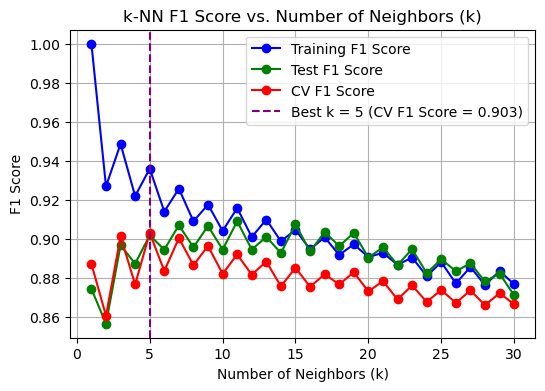

Best k: 5
Best CV F1 Score: 0.903


In [25]:
# Calling the previously defined best K (at the top in Functions section)

bestk_results = knn_best_k_f1(X_train, X_test, y_train, y_test, max_k=30, cv=10)
print("Best k:", bestk_results["best_k"])
print("Best CV F1 Score:", round(bestk_results["best_cv_f1_score"], 3))

We iterate over number of neighbour values for k-NN from 1-30 and based on 10-fold CV F1 Scores, pick k = 5 as it maximises CV We notice the spiky behaviour of the CV F1 Score which spikes down at even numbers of K and surmise this is due to arbitrary tie breaking for even number of neighbours which might be leading to lower F1 scores. Picking an odd number of 5 also avoids this problem.  


In [17]:
best_svm_model, best_svm_params, best_svm_score = tune_svm_hyperparameters(X_train, y_train)
print("Best Parameters:", best_svm_params)
print("Best F1:", best_svm_score)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   1.2s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   1.3s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   1.4s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   1.3s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   1.4s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   3.3s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   3.3s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   3.3s
[CV] END .....svc__C=0.1, svc__gamma=scale, svc__kernel=poly; total time=   3.2s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   3.4s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   3.4s
[CV] END .....svc__C=0.1, svc__gamma=scale, svc

In [18]:
svm_results = svm_classifier_with_best_params(X_train, X_test, y_train, y_test, best_params=best_svm_params)

print(best_svm_params)


# Convert the SVM results dictionary to a DataFrame with "SVM" as the classifier name
svm_df = pd.DataFrame([svm_results], index=["SVM"])

{'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [19]:
print(best_svm_params)

metrics_df = evaluate_classifiers(X_train, X_test, y_train, y_test, best_k=bestk_results["best_k"])

# Append the SVM results to the rest of the classifiers 

metrics_df = pd.concat([metrics_df, svm_df])

print(metrics_df)


{'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
                     Accuracy  Balanced Accuracy    AUC  F1 Score
LDA                     0.938              0.919  0.989     0.911
QDA                     0.949              0.943  0.988     0.931
Logistic Regression     0.957              0.951  0.992     0.942
k-NN                    0.931              0.915  0.967     0.902
GBDT                    0.943              0.934  0.985     0.922
Random Forest           0.943              0.936  0.983     0.923
SVM                     0.935              0.931  0.978     0.914


## T1.4 Best Approach Function

In [ ]:
def mypredict():
    """
    Implements the best classifier (Logistic Regression with Elastic Net Regularization)
    using the known optimal hyperparameters.

    Returns:
    Predict the class label of each row and returns the prediction labels saved in a plain text file
    (one prediction label per line)
    """
    
    data1_raw = pd.read_csv("test.csv.gz")

    # Separate the target (Y) and predictors (X)
    y = np.where(data1_raw.iloc[:, 0] == "TREG", 1, 0).astype(np.float64)  # 1 if "TREG", else 0
    X = data1_raw.iloc[:, 1:]  # all other columns are predictors
    
    # Standardize the predictor variables (important for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce to 10 components
    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame with the reduced components
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(10)])
    
    # We define the logistic regression model with optimal hyperparameters
    best_model = LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        C=1,
        l1_ratio=0.1,
        max_iter=10000
    )
    
    # We fit the model on the PCA-transformed training data
    best_model.fit(X_pca_df, y)
    
    # Evaluate the model on the test set
    y_pred = best_model.predict(X_pca_df)


    # Write predictions to a text file, one per line
    with open("output.txt", "w") as file:
        for pred in y_pred:
            file.write(f"{pred}\n")
    
    
    return y_pred